In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

### Test with a single meets raw data

C:\Users\katelorr\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ca.milesplit.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [14]:
df

,Place,Athlete,Grade,School,Time,Race
0,Place,Athlete,Grade,School,Time,M Varsity Girls - 5K Run
1,1,Abigail Errington,11,South Pasadena (SS),17:44.1,M Varsity Girls - 5K Run
2,2,Seelah Kittelstrom,11,Montgomery (NC),18:02.8,M Varsity Girls - 5K Run
3,3,Winter Moritz,12,University City (SD),18:03.9,M Varsity Girls - 5K Run
4,4,Amrie Lacefield,11,Montgomery (NC),18:14.0,M Varsity Girls - 5K Run
...,...,...,...,...,...,...
3565,227,Ruben Lepiz,9,Madera South (CS),26:50.8,XL-L Frosh-Soph Boys - 5K Run
3566,228,Mason Montag,10,Clovis East (CS),27:40.0,XL-L Frosh-Soph Boys - 5K Run
3567,229,Angel Ortega,9,Merced (SJ),28:46.1,XL-L Frosh-Soph Boys - 5K Run
3568,230,Brody Vang,9,Merced (SJ),28:47.4,XL-L Frosh-Soph Boys - 5K Run


In [14]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
import random
import urllib3

# Suppress only the single InsecureRequestWarning from urllib3 needed
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


# Define the parameters and root URL
params = {
    'years': list(range(2011, 2025)),
    'months': list(range(8, 13)),
    'seasons': ['outdoor'],
    'level': ['hs']
}

root_url = "https://ca.milesplit.com/results/?"

# Generate the URLs for a specific year
def generate_urls_for_year(year):
    return [
        f"{root_url}year={year}&month={month}&season={season}&level={level}"
        for month in params['months']
        for season in params['seasons']
        for level in params['level']
    ]

# Function to make GET requests with pagination and extract data
def fetch_data(url):
    page = 1
    data = []
    headers = ['date', 'name', 'location', 'photos', 'videos', 'href_url', 'paginated_url']
    while True:
        paginated_url = f"{url}&page={page}"
        response = requests.get(paginated_url, verify=False)
        if response.status_code != 200:
            break
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table')
        if not table:
            print(f"No table found for URL: {paginated_url}")
            break
        # Check if the table has content
        rows = table.find_all('tr')
        if not rows:
            print(f"Table found but it has no content for URL: {paginated_url}")
            break
        # Extract table data
        for row in rows:
            # Skip rows with the class "thead month heading"
            if "thead month heading" in row.get("class", []):
                continue
            cells = row.find_all('td')
            if not cells:
                print(f"No cells found in row for URL: {paginated_url}")
                continue
            row_data = []
            for cell in cells:
                cell_class = cell.get('class', [''])[0]
                if cell_class in headers:
                    row_data.append(cell.text.strip())
                else:
                    print(f"Unexpected class '{cell_class}' found in row, skipping element.")
            # Extract the href URL from the name element
            name_element = row.find('td', class_='name')
            if name_element:
                a_tag = name_element.find('a')
                href_url = a_tag['href'] if a_tag else None
            else:
                href_url = None
            row_data.append(href_url)
            # Append the URL to the row_data
            row_data.append(paginated_url)
            data.append(row_data)
        page += 1
        # Introduce a random pause between 1 and 5 seconds after each request
        time.sleep(random.uniform(1, 5))
    return headers, data

# Ensure the "data" folder exists
os.makedirs("data", exist_ok=True)

# Process data for each year separately
def process_data_for_year(year):
    all_data = []
    all_headers = None
    year_urls = generate_urls_for_year(year)
    for url in year_urls:
        headers, data = fetch_data(url)
        if all_headers is None:
            all_headers = headers
        if data:
            all_data.extend(data)
    return all_headers, all_data

# Save data to CSV
def save_data_to_csv(headers, data, year):
    df = pd.DataFrame(data, columns=headers)
    df['year'] = df['paginated_url'].str.extract(r'year=(\d+)')
    df['month'] = df['paginated_url'].str.extract(r'month=(\d+)')
    df['season'] = df['paginated_url'].str.extract(r'season=(\w+)')
    df['level'] = df['paginated_url'].str.extract(r'level=(\w+)')
    df['page'] = df['paginated_url'].str.extract(r'page=(\d+)')
    csv_path = os.path.join("data", f"api_responses_{year}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Data for year {year} saved to {csv_path}")

# Main function to process and save data for each year
def main():
    for year in params['years']:
        headers, data = process_data_for_year(year)
        if headers and data:
            save_data_to_csv(headers, data, year)

if __name__ == "__main__":
    main()

No cells found in row for URL: https://ca.milesplit.com/results/?year=2011&month=8&season=outdoor&level=hs&page=1
Table found but it has no content for URL: https://ca.milesplit.com/results/?year=2011&month=8&season=outdoor&level=hs&page=2
No cells found in row for URL: https://ca.milesplit.com/results/?year=2011&month=9&season=outdoor&level=hs&page=1
Unexpected class 'offset' found in row, skipping element.
Unexpected class 'adSlot' found in row, skipping element.
No cells found in row for URL: https://ca.milesplit.com/results/?year=2011&month=9&season=outdoor&level=hs&page=2
Unexpected class 'offset' found in row, skipping element.
Unexpected class 'adSlot' found in row, skipping element.
Table found but it has no content for URL: https://ca.milesplit.com/results/?year=2011&month=9&season=outdoor&level=hs&page=3
No cells found in row for URL: https://ca.milesplit.com/results/?year=2011&month=10&season=outdoor&level=hs&page=1
Unexpected class 'offset' found in row, skipping element.
U

In [17]:
import os
import pandas as pd
import glob

# Define the path to the data folder
data_folder = "data"

# Use glob to find all CSV files matching the pattern
csv_files = glob.glob(os.path.join(data_folder, "api_responses_*.csv"))

# List to hold individual DataFrames
dataframes = []

# Read each CSV file into a DataFrame and append to the list
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Drop rows where the 'date' column is null
combined_df = combined_df.dropna(subset=['date'])

# Optionally, save the combined DataFrame to a new CSV file
combined_csv_path = os.path.join(data_folder, "combined_api_responses.csv")
combined_df.to_csv(combined_csv_path, index=False)
print(f"Combined data saved to {combined_csv_path}")

Combined data saved to data\combined_api_responses.csv


In [18]:
df = pd.read_csv("data/combined_api_responses.csv")
df


,date,name,location,photos,videos,href_url,paginated_url,year,month,season,level,page
0,8/30,Moorpark Invitational,"Moorpark, CA",NaN,NaN,https://ca.milesplit.com/meets/42018-moorpark-...,https://ca.milesplit.com/results/?year=2008&mo...,2008.0,8.0,outdoor,hs,1.0
1,8/30,Willow Hills Reservoir Relays,"Folsom, CA",NaN,NaN,https://ca.milesplit.com/meets/39760-willow-hi...,https://ca.milesplit.com/results/?year=2008&mo...,2008.0,8.0,outdoor,hs,1.0
2,8/29,Nevada Twilight Classic,"Reno, NV",NaN,NaN,https://nv.milesplit.com/meets/40011-nevada-tw...,https://ca.milesplit.com/results/?year=2008&mo...,2008.0,8.0,outdoor,hs,1.0
3,8/24,Jason E. Walton Memorial Run,"Hillsborough, NJ",NaN,NaN,https://nj.milesplit.com/meets/40210-jason-e-w...,https://ca.milesplit.com/results/?year=2008&mo...,2008.0,8.0,outdoor,hs,1.0
4,9/27,Bell-Jeff Invitational,"Los Angeles, CA",NaN,NaN,https://ca.milesplit.com/meets/40664-bell-jeff...,https://ca.milesplit.com/results/?year=2008&mo...,2008.0,9.0,outdoor,hs,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7349,12/12,Malagon Mile,"North Hills, CA",NaN,NaN,https://ca.milesplit.com/meets/650592-malagon-...,https://ca.milesplit.com/results/?year=2024&mo...,2024.0,12.0,outdoor,hs,1.0
7350,12/7,Foot Locker West Regional,"Walnut, CA",NaN,NaN,https://www.milesplit.com/meets/647353-foot-lo...,https://ca.milesplit.com/results/?year=2024&mo...,2024.0,12.0,outdoor,hs,1.0
7351,12/7,Nike Cross Nationals,"Portland, OR",NaN,NaN,https://www.milesplit.com/meets/646224-nike-cr...,https://ca.milesplit.com/results/?year=2024&mo...,2024.0,12.0,outdoor,hs,1.0
7352,12/7\n12/8,North Texas Showcase,"Haslet, TX",NaN,NaN,https://tx.milesplit.com/meets/634792-north-te...,https://ca.milesplit.com/results/?year=2024&mo...,2024.0,12.0,outdoor,hs,1.0


In [20]:
df.location.nunique()

556

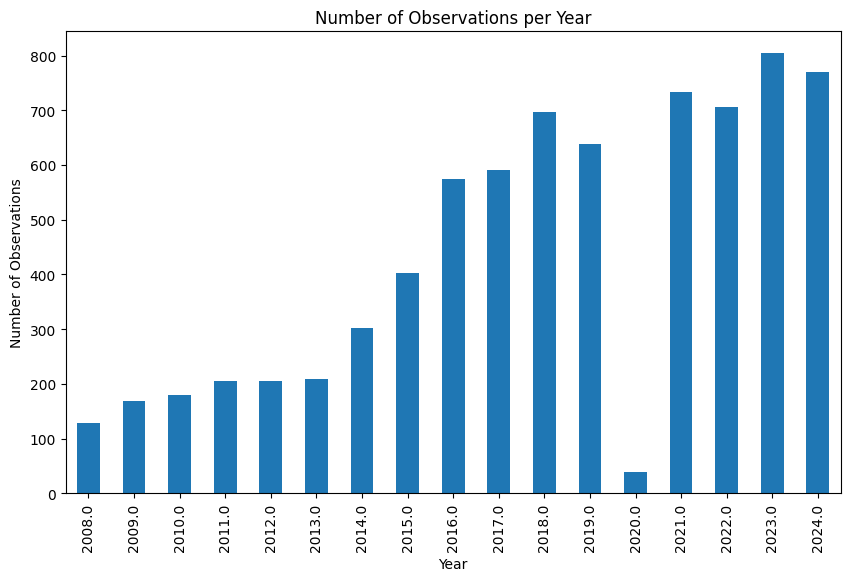

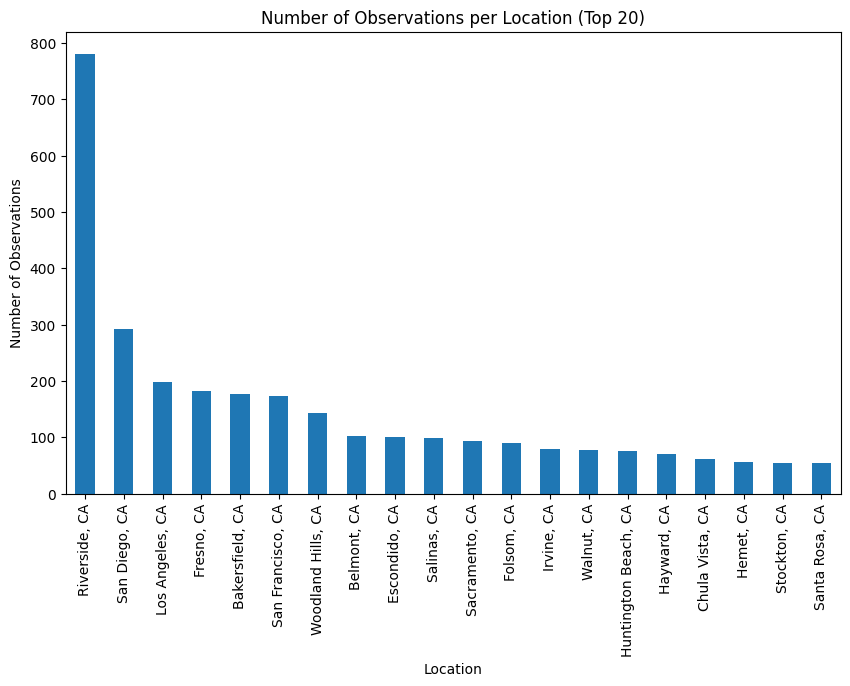

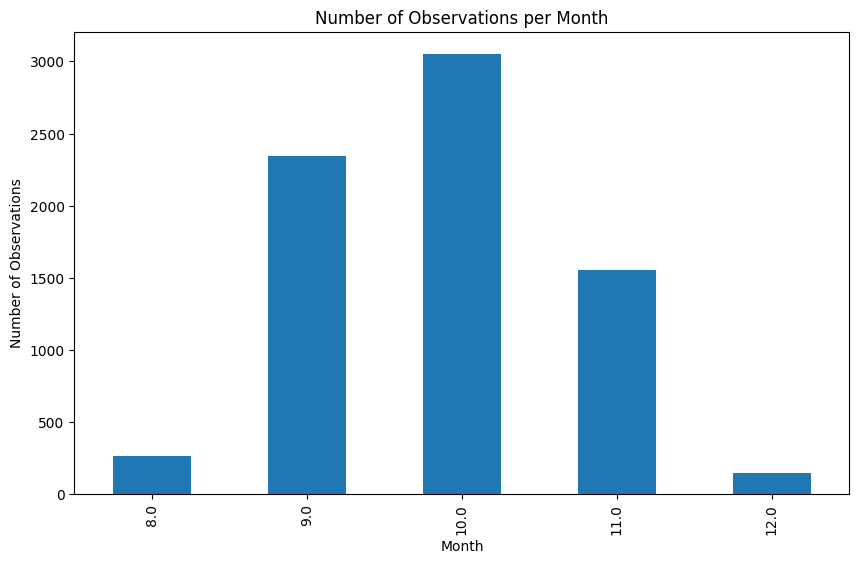

In [19]:
import matplotlib.pyplot as plt

# Histogram of observations per year
plt.figure(figsize=(10, 6))
combined_df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Observations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.show()

# Histogram of observations per location
plt.figure(figsize=(10, 6))
combined_df['location'].value_counts().head(20).plot(kind='bar')
plt.title('Number of Observations per Location (Top 20)')
plt.xlabel('Location')
plt.ylabel('Number of Observations')
plt.show()

# Histogram of observations per month
plt.figure(figsize=(10, 6))
combined_df['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Observations per Month')
plt.xlabel('Month')
plt.ylabel('Number of Observations')
plt.show()

<Figure size 1200x800 with 0 Axes>

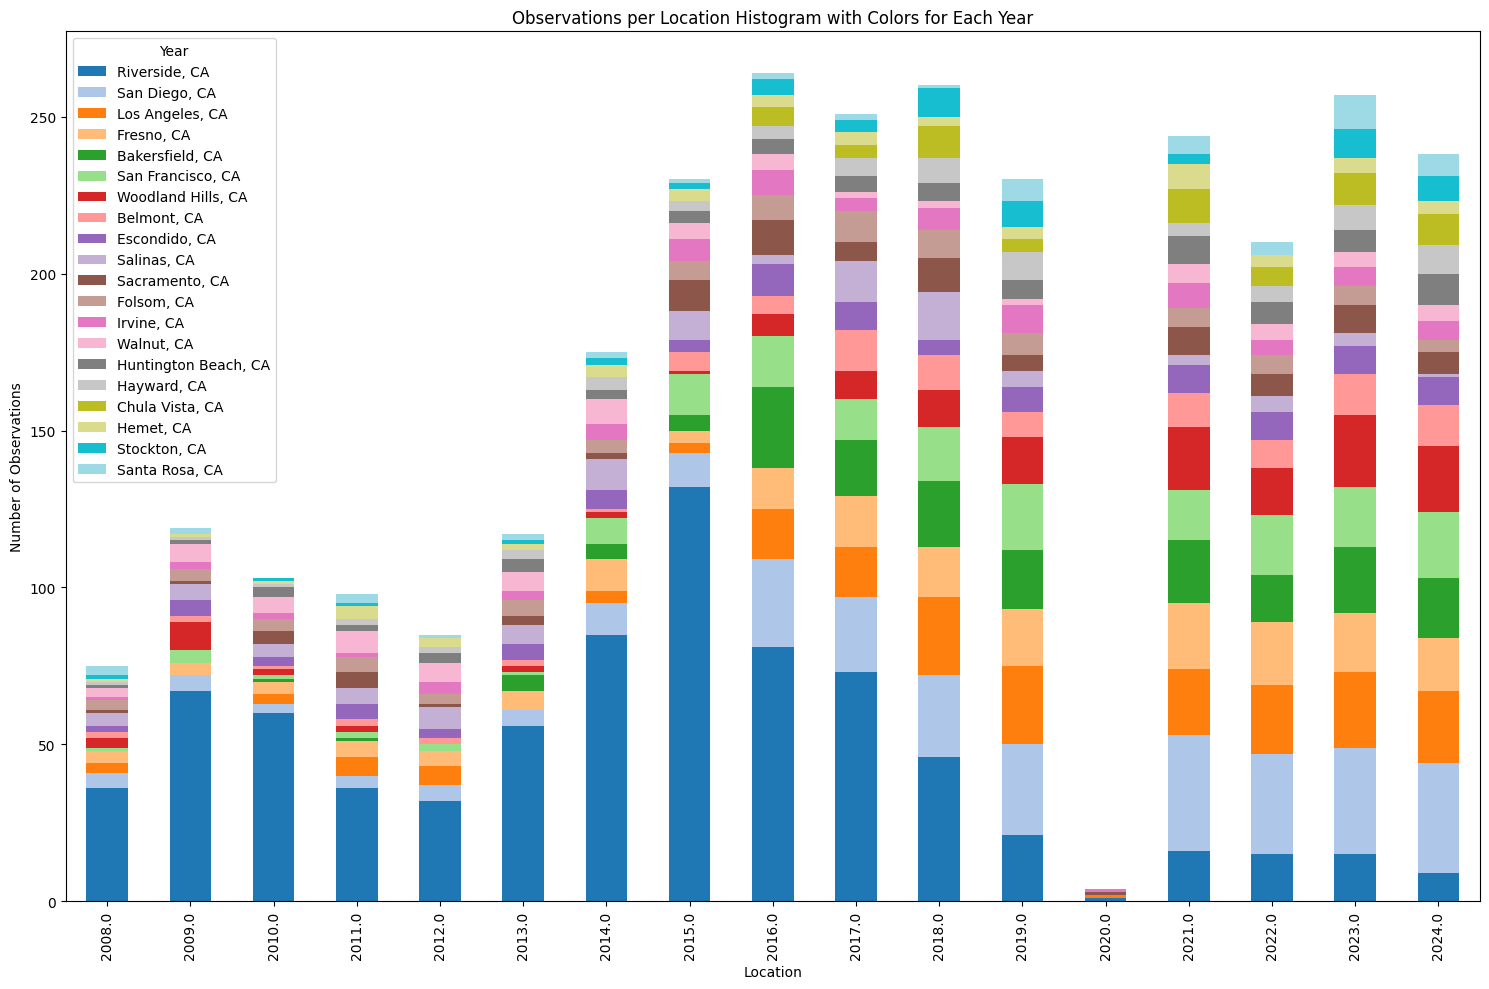

In [25]:
# Identify the top 20 locations based on the number of observations
top_locations = df['location'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top 20 locations
filtered_df = df[df['location'].isin(top_locations)]

# Create a histogram of observations per location with colors for each year
plt.figure(figsize=(12, 8))

# Group by year and location, then count the observations
grouped = filtered_df.groupby(['year', 'location']).size().unstack(fill_value=0)

# Sort the DataFrame by the total number of observations per location
grouped = grouped.loc[:, grouped.sum().sort_values(ascending=False).index]

# Plot the histogram
grouped.plot(kind='bar', stacked=True, colormap='tab20', figsize=(15, 10))

plt.title('Observations per Location Histogram with Colors for Each Year')
plt.xlabel('Location')
plt.ylabel('Number of Observations')
plt.legend(title='Year')
plt.xticks(rotation=90)
plt.tight_layout()